# Alzheimer MRI Classification with Deep Learning (ResNet18 + Explainability)

In this notebook, we build a deep-learning–based classifier to detect different stages of Alzheimer’s disease from structural MRI images.
We use a ResNet18 backbone with transfer learning, evaluate the model across multiple metrics, and apply Grad-CAM for explainability.

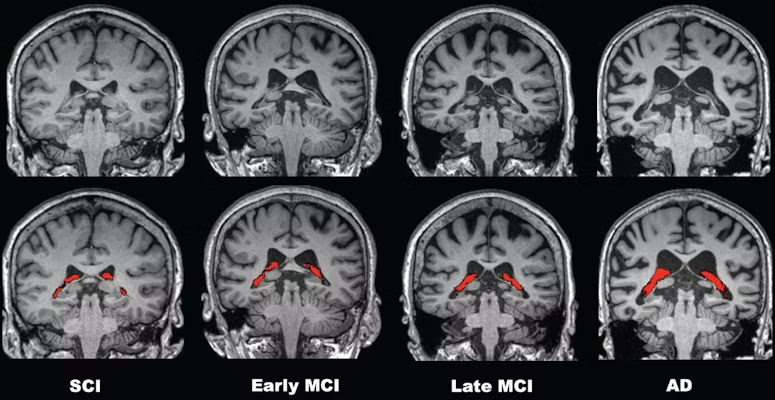

Goals:
- Prepare the dataset by splitting raw MRI images into train/validation/test sets.
- Load and visualize the MRI samples for sanity checking.
- Train a supervised image classifier (ResNet18 with ImageNet pretraining).
- Handle data imbalance using class weights.
- Evaluate model performance using:
  - accuracy and loss curves
  - confusion matrix & per-class metrics
  - multi-class ROC and AUC
- Interpret the model with Grad-CAM to visualize where the network focuses during predictions.
- Produce plots and metrics suitable for reports or presentations, including ROC curves and explainability heatmaps.

In [11]:
# standard libraries
import os
import zipfile
import random
import shutil

# data handling
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# scikit-learn utilities and metrics
from sklearn.utils import compute_class_weight  # class weights for imbalanced data
from sklearn.metrics import (
    roc_curve,           # ROC curve
    roc_auc_score,       # ROC AUC
    confusion_matrix,    # confusion matrix
    precision_recall_curve,
    average_precision_score,
    classification_report
)
from sklearn.preprocessing import label_binarize  # for multi-class ROC

In [14]:
# seed - reproducibility
seed = 42

def set_seed(seed=seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(seed)

In [37]:
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon MPS")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA GPU:", torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print("Using CPU only")

Using Apple Silicon MPS


# Dataset
We used the “Augmented Alzheimer MRI Dataset” from Kaggle (https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset), which contains MRI images of four classes (Mild Demented, Moderate Demented, Non-Demented, Very Mild Demented). The dataset was publicly available and downloaded under GNU Lesser General Public License 3.0

In [16]:
# paths
base_path = r"Dataset/AugmentedAlzheimerDataset"
working_dir = r"Dataset/Alzheimer_Split"

# create train, validation, test folders
for split in ['train', 'validation', 'test']:
    os.makedirs(os.path.join(working_dir, split), exist_ok=True)

# split dataset
def split_data(base_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=seed):
    set_seed(seed)
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        splits = {
            'train': images[:n_train],
            'validation': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split_name, split_files in splits.items():
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in split_files:
                src = os.path.join(class_path, file)
                dst = os.path.join(split_class_dir, file)
                shutil.copy(src, dst)

    print("Dataset successfully split into train/validation/test folders.")
        
print("Splitting dataset...")
split_data(base_path, working_dir)

Splitting dataset...
Dataset successfully split into train/validation/test folders.


In [24]:
# counts images in directory
def count_images_in_directory(directory):
    class_counts = {}
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return class_counts
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            class_counts[class_name] = len(images)
    return class_counts

# count dataset after splitting
print("Dataset statistics after splitting")
print("-"*70 + "\n")

def print_dataset_stats(name, counts):
    total = 0
    print(f"{name} set:")
    for class_name, count in sorted(counts.items()):
        print(f"  {class_name}: {count} images")
        total += count
    print(f"  Total {name} Images: {total}\n")
    return total

train_counts = count_images_in_directory(os.path.join(working_dir, 'train'))
val_counts = count_images_in_directory(os.path.join(working_dir, 'validation'))
test_counts = count_images_in_directory(os.path.join(working_dir, 'test'))
total_train = print_dataset_stats("Training", train_counts)
total_val = print_dataset_stats("Validation", val_counts)
total_test = print_dataset_stats("Test", test_counts)

print("-"*70)
print(f"Grand Total: {total_train + total_val + total_test} images\n")

Dataset statistics after splitting
----------------------------------------------------------------------

Training set:
  MildDemented: 7168 images
  ModerateDemented: 5171 images
  NonDemented: 7680 images
  VeryMildDemented: 7168 images
  Total Training Images: 27187

Validation set:
  MildDemented: 896 images
  ModerateDemented: 646 images
  NonDemented: 960 images
  VeryMildDemented: 896 images
  Total Validation Images: 3398

Test set:
  MildDemented: 896 images
  ModerateDemented: 647 images
  NonDemented: 960 images
  VeryMildDemented: 896 images
  Total Test Images: 3399

----------------------------------------------------------------------
Grand Total: 33984 images



In [33]:
# class names
class_names = sorted(train_counts.keys())
num_classes = len(class_names)
print(f"\nDetected Classes ({num_classes}): {class_names}\n")

# train, validation, test paths
train_dir = os.path.join(working_dir, 'train')
val_dir   = os.path.join(working_dir, 'validation')
test_dir  = os.path.join(working_dir, 'test')

print("-"*70)
print(f"Paths ready for model:")
print(f"  Train directory     : {train_dir}")
print(f"  Validation directory: {val_dir}")
print(f"  Test directory      : {test_dir}\n")


Detected Classes (4): ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

----------------------------------------------------------------------
Paths ready for model:
  Train directory     : Dataset/Alzheimer_Split/train
  Validation directory: Dataset/Alzheimer_Split/validation
  Test directory      : Dataset/Alzheimer_Split/test



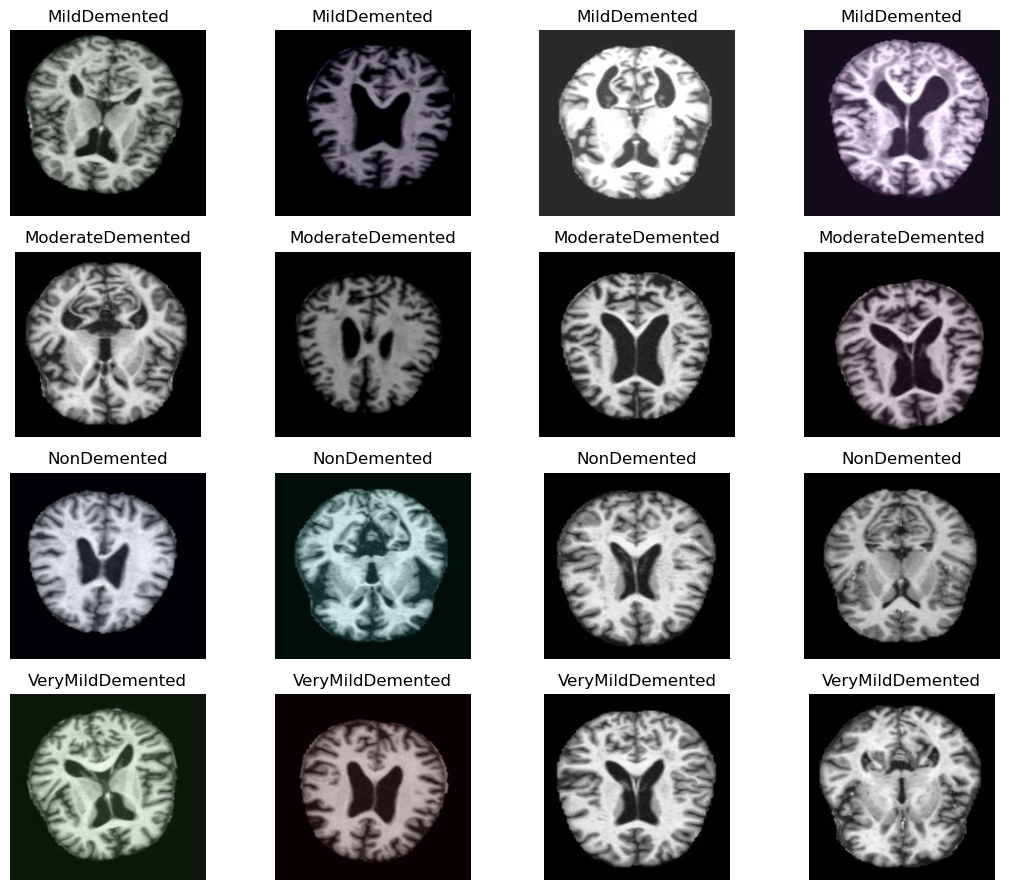

In [34]:
# Display sample images from training set
def display_sample_images(directory, num_images=4):
    plt.figure(figsize=(11, 9))
    i = 0
    for category in class_names:  
        category_path = os.path.join(directory, category)
        if not os.path.exists(category_path):
            continue
        image_files = [f for f in os.listdir(category_path) 
                       if os.path.isfile(os.path.join(category_path, f))][:num_images]
        for img_file in image_files:
            img_path = os.path.join(category_path, img_file)
            img = Image.open(img_path) 

            plt.subplot(len(class_names), num_images, i + 1)
            plt.imshow(img)
            plt.title(f"{category}")
            plt.axis('off')
            i += 1
            if i >= len(class_names) * num_images:  
                break
        if i >= len(class_names) * num_images:
            break
    plt.tight_layout()
    plt.show()

display_sample_images(train_dir, num_images=4)

In [35]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Classes from ImageFolder:", train_dataset.classes)
print("Train/Val/Test sizes:", len(train_dataset), len(val_dataset), len(test_dataset))

Classes from ImageFolder: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Train/Val/Test sizes: 27187 3398 3399


## Compute class weights to handle imbalance

In [39]:
all_train_labels = [label for _, label in train_dataset.samples]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=all_train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("Class weights:", class_weights)

Class weights: tensor([0.9482, 1.3144, 0.8850, 0.9482], device='mps:0')


## ResNet18 Model

In [40]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# replace final fc layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)  # 用 class weight
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

print(model.fc)

Linear(in_features=512, out_features=4, bias=True)


## Train and Evaluation

In [41]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [42]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)

        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)

        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)

    return epoch_loss, epoch_acc, all_labels, all_preds, all_probs

## Start Training

In [44]:
NUM_EPOCHS = 10

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

best_val_loss = float("inf")
best_model_path = "best_resnet18_alzheimer.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_y_true, val_y_pred, val_y_prob = evaluate(model, val_loader, criterion, DEVICE)

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("  -> Saved best model.")

print("Training finished. Best val loss:", best_val_loss)

/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/10 | Train Loss: 0.5026 Acc: 0.7685 | Val Loss: 0.2699 Acc: 0.8876
  -> Saved best model.
Epoch 02/10 | Train Loss: 0.1668 Acc: 0.9321 | Val Loss: 0.1806 Acc: 0.9353
  -> Saved best model.
Epoch 03/10 | Train Loss: 0.0881 Acc: 0.9657 | Val Loss: 0.0785 Acc: 0.9703
  -> Saved best model.
Epoch 04/10 | Train Loss: 0.0572 Acc: 0.9779 | Val Loss: 0.0500 Acc: 0.9823
  -> Saved best model.
Epoch 05/10 | Train Loss: 0.0473 Acc: 0.9825 | Val Loss: 0.0442 Acc: 0.9823
  -> Saved best model.
Epoch 06/10 | Train Loss: 0.0370 Acc: 0.9863 | Val Loss: 0.0372 Acc: 0.9885
  -> Saved best model.
Epoch 07/10 | Train Loss: 0.0342 Acc: 0.9874 | Val Loss: 0.0565 Acc: 0.9773
Epoch 08/10 | Train Loss: 0.0286 Acc: 0.9897 | Val Loss: 0.0551 Acc: 0.9791
Epoch 09/10 | Train Loss: 0.0294 Acc: 0.9892 | Val Loss: 0.0217 Acc: 0.9938
  -> Saved best model.
Epoch 10/10 | Train Loss: 0.0263 Acc: 0.9904 | Val Loss: 0.0605 Acc: 0.9832
Training finished. Best val loss: 0.021652878507408154


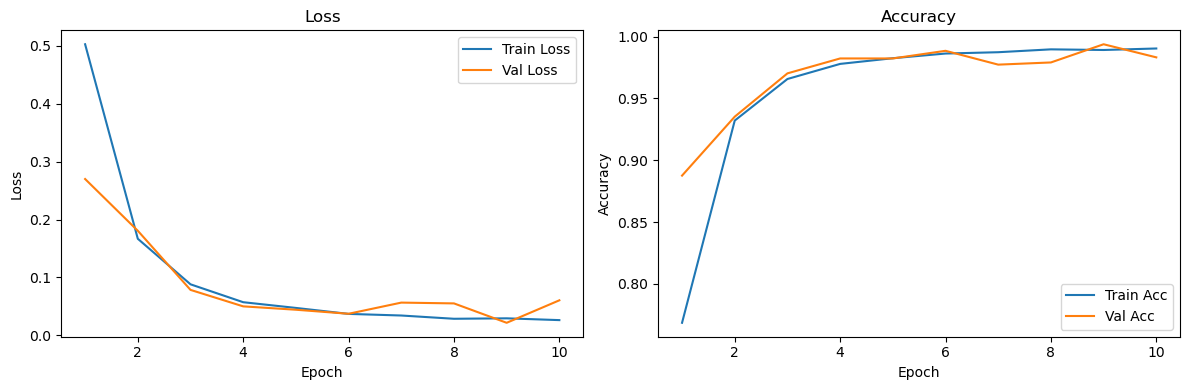

In [45]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()

## Best Model

In [49]:
best_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = best_model.fc.in_features
best_model.fc = nn.Linear(in_features, num_classes)
best_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
best_model = best_model.to(DEVICE)

test_loss, test_acc, y_true, y_pred, y_prob = evaluate(best_model, test_loader, criterion, DEVICE)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.0231 | Test Acc: 0.9932


## Confusion Matrix & Classification Report

Confusion Matrix:
 [[890   0   0   6]
 [  0 647   0   0]
 [  3   0 951   6]
 [  1   0   7 888]]


<Figure size 600x600 with 0 Axes>

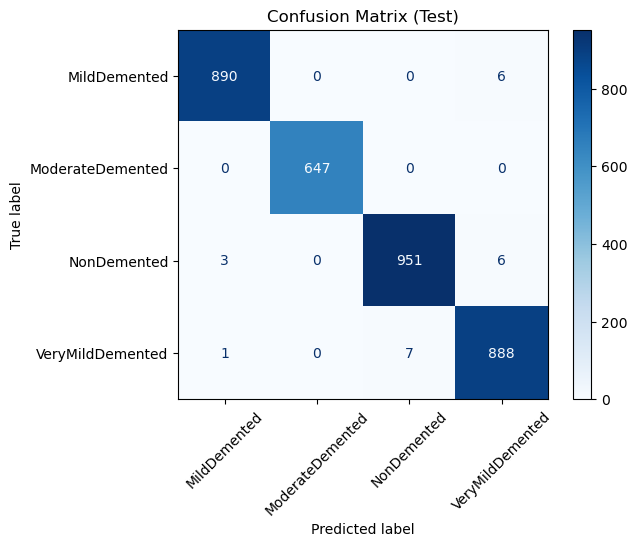

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       1.00      0.99      0.99       896
ModerateDemented       1.00      1.00      1.00       647
     NonDemented       0.99      0.99      0.99       960
VeryMildDemented       0.99      0.99      0.99       896

        accuracy                           0.99      3399
       macro avg       0.99      0.99      0.99      3399
    weighted avg       0.99      0.99      0.99      3399



In [50]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix (Test)")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## ROC AUC

In [51]:
# use true label for one-hot
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

roc_auc_per_class = {}
for i, cls_name in enumerate(class_names):
    try:
        auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
    except ValueError:
        auc = float("nan")
    roc_auc_per_class[cls_name] = auc

print("ROC AUC per class:")
for cls_name, auc in roc_auc_per_class.items():
    print(f"{cls_name}: {auc:.4f}")

ROC AUC per class:
MildDemented: 0.9999
ModerateDemented: 1.0000
NonDemented: 0.9998
VeryMildDemented: 0.9996


# Grad-CAM